In [1]:
import sys
sys.path.insert(1, "..")
sys.path.insert(2, "../..")

import tqdm
import torch
import pandas as pd;
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast
from huggingface_hub import login
import time
import os

from patch import *

In [2]:
DEVICE = "cpu" # cpu or cuda
METHOD = "Naive" # RSR or Naive
MODEL = "tiiuae/Falcon3-3B-Instruct-1.58bit" # [HF1BitLLM/Llama3-8B-1.58-100B-tokens, tiiuae/Falcon3-3B-Instruct-1.58bit]
TOKENIZER = "tiiuae/Falcon3-3B-Instruct-1.58bit" # [meta-llama/Meta-Llama-3-8B-Instruct, tiiuae/Falcon3-3B-Instruct-1.58bit]

In [3]:
# Don't run this cell if you want to see the 'Optimized Standard Inference'
apply_patch(method=METHOD)

In [4]:
if DEVICE == "cpu":
    os.environ["CUDA_VISIBLE_DEVICES"] = ''
    
os.environ["HF_TOKEN"]="YOUR TOKEN HERE"
print("cuda available? ", torch.cuda.is_available())

cuda available?  False


In [6]:
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)
device = torch.device(DEVICE)

model = LlamaForCausalLM.from_pretrained(MODEL, 
                                         device_map=DEVICE, 
                                         torch_dtype=torch.bfloat16).to(device)
tokenizer = PreTrainedTokenizerFast.from_pretrained(TOKENIZER)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


HF_Quantizer: <transformers.quantizers.quantizer_bitnet.BitNetHfQuantizer object at 0x7fb23a646380>
** hf_quantizer.preprocess_model
** hf_quantizer.postprocess_model


tokenizer_config.json:   0%|          | 0.00/365k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

### Inference

In [7]:
def infer(prompt, max_length=20, tokens_to_generate=1):
    start_time = time.time()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)#.cuda()
    output = model.generate(input_ids, max_length=max_length, do_sample=False, max_new_tokens=tokens_to_generate);
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True);
    print(f"{prompt} --> {generated_text}")
    return {
        "time": time.time() - start_time,
        "response": generated_text,
        "device": DEVICE,
        "method": METHOD
    }

### Questions Dataset

In [8]:
df = pd.read_csv("../datasets/questions_df.csv")
df.head()

,q
0,What is the capital of France?
1,Who wrote Romeo and Juliet?
2,What is 2 + 2?
3,What is the largest planet in the solar system?
4,Who painted the Mona Lisa?


In [9]:
result = []

for i, question in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    result.append(infer(prompt=question["q"])) 

  0%|          | 0/10 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Input ID: torch.Size([1, 7]), Input Embed:torch.Size([1, 7, 3072])


 10%|█         | 1/10 [01:00<09:06, 60.77s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is the capital of France? --> What is the capital of France?

Input ID: torch.Size([1, 6]), Input Embed:torch.Size([1, 6, 3072])


 20%|██        | 2/10 [01:53<07:26, 55.87s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Who wrote Romeo and Juliet? --> Who wrote Romeo and Juliet?

Input ID: torch.Size([1, 9]), Input Embed:torch.Size([1, 9, 3072])


 30%|███       | 3/10 [03:06<07:28, 64.01s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is 2 + 2? --> What is 2 + 2?

Input ID: torch.Size([1, 10]), Input Embed:torch.Size([1, 10, 3072])


 30%|███       | 3/10 [04:21<10:10, 87.20s/it]


KeyboardInterrupt: 

In [10]:
pd.DataFrame(result).to_csv("./report/RSR_Questions_Falcon10.csv", index=0)

### SimpleQuestions Dataset

In [11]:
import random

random.seed(2)

lines = []
with open("../datasets/annotated_wd_data_test.txt", "r") as f:
    lines = f.readlines()
    lines = random.sample(lines, 20)

lines = [l.split("\t")[-1].strip() for l in lines]
lines[:2]

['What kind of music is anthems for worship?',
 "what was billy walton's football position?"]

In [12]:
result = []

for row in tqdm.tqdm(lines):
    result.append(infer(prompt=row, max_length=20)) 

  0%|          | 0/20 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Input ID: torch.Size([1, 9]), Input Embed:torch.Size([1, 9, 3072])


  5%|▌         | 1/20 [00:19<06:17, 19.86s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What kind of music is anthems for worship? --> What kind of music is anthems for worship?
Input ID: torch.Size([1, 10]), Input Embed:torch.Size([1, 10, 3072])


 10%|█         | 2/20 [00:41<06:14, 20.80s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


what was billy walton's football position? --> what was billy walton's football position?

Input ID: torch.Size([1, 10]), Input Embed:torch.Size([1, 10, 3072])


 15%|█▌        | 3/20 [01:02<05:58, 21.07s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


which footballer was born in canton of nidwalden --> which footballer was born in canton of nidwalden 
Input ID: torch.Size([1, 11]), Input Embed:torch.Size([1, 11, 3072])


 20%|██        | 4/20 [01:26<05:51, 21.95s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Which city and country was toni branca born in --> Which city and country was toni branca born in?
Input ID: torch.Size([1, 8]), Input Embed:torch.Size([1, 8, 3072])


 25%|██▌       | 5/20 [01:44<05:08, 20.53s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Who is a politician born in gloucester --> Who is a politician born in gloucestershire
Input ID: torch.Size([1, 9]), Input Embed:torch.Size([1, 9, 3072])


 30%|███       | 6/20 [02:03<04:42, 20.17s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What genre of film is ram-avtar --> What genre of film is ram-avtar?
Input ID: torch.Size([1, 17]), Input Embed:torch.Size([1, 17, 3072])


 35%|███▌      | 7/20 [02:37<05:21, 24.71s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


what did amir-abbas hoveyda die as a result of? --> what did amir-abbas hoveyda die as a result of?

Input ID: torch.Size([1, 5]), Input Embed:torch.Size([1, 5, 3072])


 40%|████      | 8/20 [02:49<04:09, 20.75s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


what is largemouth bass --> what is largemouth bass?
Input ID: torch.Size([1, 13]), Input Embed:torch.Size([1, 13, 3072])


 45%|████▌     | 9/20 [03:16<04:08, 22.57s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


who was a military personnel involved in the battle of fredericksburg --> who was a military personnel involved in the battle of fredericksburg.
Input ID: torch.Size([1, 10]), Input Embed:torch.Size([1, 10, 3072])


 50%|█████     | 10/20 [03:37<03:40, 22.09s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


what's a movie in the india netflix genre --> what's a movie in the india netflix genre?
Input ID: torch.Size([1, 10]), Input Embed:torch.Size([1, 10, 3072])


 55%|█████▌    | 11/20 [03:58<03:16, 21.83s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Name a famous Australian singer known for pop music? --> Name a famous Australian singer known for pop music?

Input ID: torch.Size([1, 8]), Input Embed:torch.Size([1, 8, 3072])


 60%|██████    | 12/20 [04:16<02:44, 20.55s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


what is the record label of afi --> what is the record label of afi k
Input ID: torch.Size([1, 10]), Input Embed:torch.Size([1, 10, 3072])


 65%|██████▌   | 13/20 [04:37<02:25, 20.78s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


who was in charge of story on jumanji --> who was in charge of story on jumanji and
Input ID: torch.Size([1, 12]), Input Embed:torch.Size([1, 12, 3072])


 70%|███████   | 14/20 [05:02<02:12, 22.03s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What country did the battle of lechfeld take place in --> What country did the battle of lechfeld take place in?
Input ID: torch.Size([1, 10]), Input Embed:torch.Size([1, 10, 3072])


 75%|███████▌  | 15/20 [05:23<01:48, 21.69s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


what is elizabeth couchman's gender? --> what is elizabeth couchman's gender?

Input ID: torch.Size([1, 6]), Input Embed:torch.Size([1, 6, 3072])


 80%|████████  | 16/20 [05:37<01:17, 19.37s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


what kind of book is night --> what kind of book is night and
Input ID: torch.Size([1, 6]), Input Embed:torch.Size([1, 6, 3072])


 85%|████████▌ | 17/20 [05:51<00:53, 17.77s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


who composed run for your life --> who composed run for your life.
Input ID: torch.Size([1, 14]), Input Embed:torch.Size([1, 14, 3072])


 90%|█████████ | 18/20 [06:19<00:41, 20.82s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Who is the former Justice of Supreme Court of Pakistan born in mumbai --> Who is the former Justice of Supreme Court of Pakistan born in mumbai?
Input ID: torch.Size([1, 8]), Input Embed:torch.Size([1, 8, 3072])


 95%|█████████▌| 19/20 [06:37<00:19, 19.87s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


which artist is considered an indie rock artist --> which artist is considered an indie rock artist?
Input ID: torch.Size([1, 9]), Input Embed:torch.Size([1, 9, 3072])


100%|██████████| 20/20 [06:56<00:00, 20.82s/it]

what label is the the delmore brothers under --> what label is the the delmore brothers under?


In [13]:
# pd.DataFrame(result).to_csv("./report/RSR_SimpleQuestions_Falcon.csv", index=0)

### TREC QA

In [14]:
df = pd.read_csv("../datasets/trecqa_test.csv")
df.head()

,label-coarse,label-fine,text
0,4,40,How far is it from Denver to Aspen ?
1,5,21,"What county is Modesto , California in ?"
2,3,12,Who was Galileo ?
3,0,7,What is an atom ?
4,4,8,When did Hawaii become a state ?


In [15]:
df = df.sample(n=20, random_state=1)

In [16]:
result = []

for i, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    result.append(infer(prompt=row["text"], max_length=20)) 

  0%|          | 0/20 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Input ID: torch.Size([1, 6]), Input Embed:torch.Size([1, 6, 3072])


  5%|▌         | 1/20 [00:14<04:31, 14.27s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


When was Hiroshima bombed ? --> When was Hiroshima bombed?

Input ID: torch.Size([1, 7]), Input Embed:torch.Size([1, 7, 3072])


 10%|█         | 2/20 [00:30<04:34, 15.25s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


How much does water weigh ? --> How much does water weigh?

Input ID: torch.Size([1, 5]), Input Embed:torch.Size([1, 5, 3072])


 15%|█▌        | 3/20 [00:42<03:55, 13.86s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What are triglycerides ? --> What are triglycerides?
Input ID: torch.Size([1, 6]), Input Embed:torch.Size([1, 6, 3072])


 20%|██        | 4/20 [00:56<03:41, 13.87s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What are spider veins ? --> What are spider veins?
Input ID: torch.Size([1, 11]), Input Embed:torch.Size([1, 11, 3072])


 25%|██▌       | 5/20 [01:19<04:17, 17.14s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Which country gave New York the Statue of Liberty ? --> Which country gave New York the Statue of Liberty?

Input ID: torch.Size([1, 6]), Input Embed:torch.Size([1, 6, 3072])


 30%|███       | 6/20 [01:33<03:45, 16.08s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is cerebral palsy ? --> What is cerebral palsy?
Input ID: torch.Size([1, 8]), Input Embed:torch.Size([1, 8, 3072])


 35%|███▌      | 7/20 [01:50<03:35, 16.54s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is the capital of Persia ? --> What is the capital of Persia?

Input ID: torch.Size([1, 7]), Input Embed:torch.Size([1, 7, 3072])


 40%|████      | 8/20 [02:06<03:16, 16.35s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Where are the Rocky Mountains ? --> Where are the Rocky Mountains?

Input ID: torch.Size([1, 10]), Input Embed:torch.Size([1, 10, 3072])


 45%|████▌     | 9/20 [02:27<03:16, 17.90s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is the criterion for being legally blind ? --> What is the criterion for being legally blind?
Input ID: torch.Size([1, 23]), Input Embed:torch.Size([1, 23, 3072])


 50%|█████     | 10/20 [03:12<04:20, 26.07s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The U.S. Department of Treasury first issued paper currency for the U.S. during which war ? --> The U.S. Department of Treasury first issued paper currency for the U.S. during which war?

Input ID: torch.Size([1, 5]), Input Embed:torch.Size([1, 5, 3072])


 55%|█████▌    | 11/20 [03:24<03:15, 21.70s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is TMJ ? --> What is TMJ?
Input ID: torch.Size([1, 12]), Input Embed:torch.Size([1, 12, 3072])


 60%|██████    | 12/20 [03:48<03:01, 22.64s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What state has the least amount of rain per year ? --> What state has the least amount of rain per year?

Input ID: torch.Size([1, 5]), Input Embed:torch.Size([1, 5, 3072])


 65%|██████▌   | 13/20 [04:01<02:16, 19.47s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Where is Perth ? --> Where is Perth?

Input ID: torch.Size([1, 9]), Input Embed:torch.Size([1, 9, 3072])


 70%|███████   | 14/20 [04:20<01:56, 19.39s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What do you call a newborn kangaroo ? --> What do you call a newborn kangaroo? A
Input ID: torch.Size([1, 7]), Input Embed:torch.Size([1, 7, 3072])


 75%|███████▌  | 15/20 [04:36<01:31, 18.31s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Where is the Savannah River ? --> Where is the Savannah River?
Input ID: torch.Size([1, 8]), Input Embed:torch.Size([1, 8, 3072])


 80%|████████  | 16/20 [04:53<01:12, 18.02s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is the birthstone for June ? --> What is the birthstone for June?

Input ID: torch.Size([1, 6]), Input Embed:torch.Size([1, 6, 3072])


 85%|████████▌ | 17/20 [05:07<00:50, 16.78s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is an ulcer ? --> What is an ulcer?
Input ID: torch.Size([1, 6]), Input Embed:torch.Size([1, 6, 3072])


 90%|█████████ | 18/20 [05:21<00:31, 15.95s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


What is strep throat ? --> What is strep throat?
Input ID: torch.Size([1, 7]), Input Embed:torch.Size([1, 7, 3072])


 95%|█████████▌| 19/20 [05:37<00:15, 15.99s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=1) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Where are the National Archives ? --> Where are the National Archives?

Input ID: torch.Size([1, 7]), Input Embed:torch.Size([1, 7, 3072])


100%|██████████| 20/20 [05:53<00:00, 17.66s/it]

Who is a German philosopher ? --> Who is a German philosopher?


In [17]:
pd.DataFrame(result).to_csv("./report/RSR_Trec_Falcon.csv", index=0)

### Reports

In [8]:
pd.read_csv("./report/Naive_Trec_Falcon10.csv", index_col=False)["time"].describe()

count     20.000000
mean     326.410688
std      151.095275
min      207.788311
25%      248.496185
50%      287.492259
75%      336.850179
max      884.360934
Name: time, dtype: float64

### Visualization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


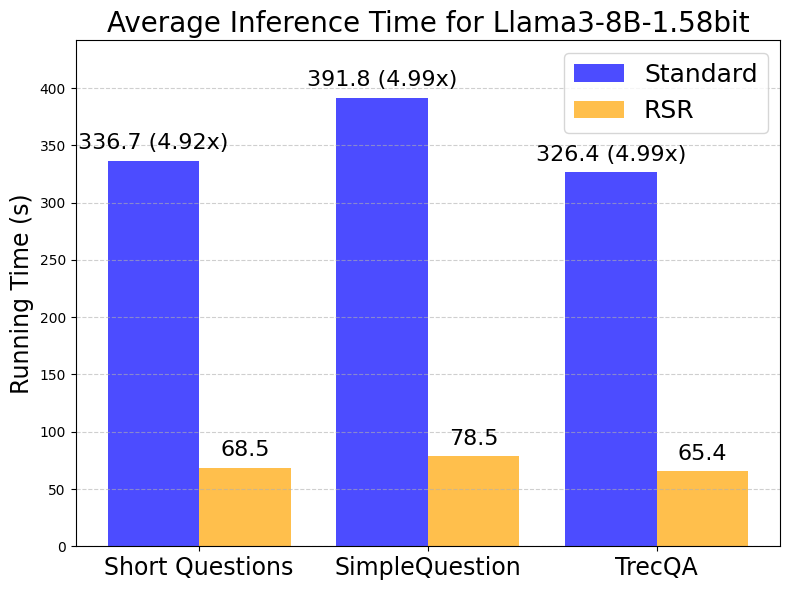

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
datasets = ['Short Questions', 'SimpleQuestion', 'TrecQA']
# Falcon3-10B-Instruct-1.58bit
# standard_times = [336.6, 391.8, 326.4]
# rsr_times = [68.5, 78.4, 65.3]

# falcon
# standard_times = [96.9, 101.4, 72.4]
# rsr_times = [18.5, 20.8, 17.6]

# Llama3-8B-1.58-100B-tokens
standard_times = [336.7, 391.8, 326.4]
rsr_times = [68.5, 78.5, 65.4]

# Calculate speedup factors
speedup_factors = [std / rsr for std, rsr in zip(standard_times, rsr_times)]

# Bar positions and width
x = np.arange(len(datasets))
bar_width = 0.4

# Plot bars for running times
fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - bar_width/2, standard_times, bar_width, label='Standard', alpha=0.7, color='blue')
bars2 = ax.bar(x + bar_width/2, rsr_times, bar_width, label='RSR', alpha=0.7, color='orange')

# Configure the y-axis
ax.set_ylabel('Running Time (s)', fontsize=17)
ax.set_title('Average Inference Time for Llama3-8B-1.58bit', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=17)
ax.legend(loc='upper right', fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add data labels to bars
for i, bar in enumerate(bars1):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10,
        f'{bar.get_height():.1f} ({speedup_factors[i]:.2f}x)',
        ha='center',
        fontsize=16,
    )
for bar in bars2:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 10,
        f'{bar.get_height():.1f}',
        ha='center',
        fontsize=16
    )

# Adjust y-axis limits for better visualization
ax.set_ylim(0, max(standard_times) + 50)  # Add some padding to the top

# Show plot
plt.tight_layout()
plt.savefig("time_compare_llama.eps", format="eps")
plt.show()
